# T5 PCA Visualization

In this notebook we will visualize the PCA projection of hidden state vector extracted from our model.

## Initialization


In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from Model import T5Sentinel
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

In [2]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_WEBTEXT = Path(PATH_ROOT, "data", "open-web-text-split")
PATH_GPTTEXT = Path(PATH_ROOT, "data", "open-gpt-text-split")

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_CHECKPT = Path(PATH_CACHE, "t5.small.0422.pt")

PATH_FIG = Path(PATH_ROOT, "result", "figures", "PCA")

In [3]:
class DualDataset(torch.utils.data.Dataset):
    def __init__(self, webTextPath: str, gptTextPath: str) -> None:
        super().__init__()

        # load from filesystem

        gptText = pd.read_json(gptTextPath, lines=True)['text']
        gptUID  = pd.read_json(gptTextPath, lines=True)['uid']
        all_uids = {uid for uid in gptUID}

        webData = pd.read_json(webTextPath, lines=True)
        webData = webData.loc[webData['uid'].isin(all_uids)]
        webText = webData["text"]
        webUID  = webData["uid"]

        # label accordingly
        self.data = [(text, 0) for text in webText] + [(text, 1) for text in gptText]
        self.uid  = [(uid, 0) for uid in webUID] + [(uid, 1) for uid in gptUID]
        self.length = len(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index: int):
        return self.data[index], self.uid[index]

In [10]:
def pca_analysis(hidden_states, title="", output="", x_range=None, y_range=None):
    real_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-web")]
    fake_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-gpt")]
    real_Harray = np.concatenate(real_hidden, axis=0)
    fake_Harray = np.concatenate(fake_hidden, axis=0)

    real_Harray = real_Harray.reshape((len(real_hidden), -1))
    fake_Harray = fake_Harray.reshape((len(fake_hidden), -1))
    # real_Harray = real_Harray.squeeze(axis=1)
    # fake_Harray = fake_Harray.squeeze(axis=1)

    print(real_Harray.shape, fake_Harray.shape)
    
    if pca_analysis.core == None:
        pca_analysis.core = PCA(n_components=2)
        pca_analysis.core.fit(np.concatenate([real_Harray, fake_Harray], axis=0))
    
    real_pca = pca_analysis.core.transform(real_Harray)
    fake_pca = pca_analysis.core.transform(fake_Harray)
    plt.figure(dpi=200)
    plt.title(title)
    if x_range is not None: plt.xlim(x_range)
    if y_range is not None: plt.ylim(y_range)
    plt.scatter(real_pca[:, 0], real_pca[:, 1], label="OpenWebText"  , s=1)
    plt.scatter(fake_pca[:, 0], fake_pca[:, 1], label="OpenGPTText" , s=1)
    plt.legend()
    plt.savefig(Path(PATH_FIG, output))


setattr(pca_analysis, "core", None)

## Data Loading

Load the dataset, etc.

In [5]:
checkpoint = torch.load(PATH_CHECKPT, map_location="cpu")
print("Loading", PATH_CHECKPT)
print("with validation acc:", checkpoint["validAccuracy"], end="\n\n")

Loading d:\Git-Project\GPT-Sentinel\result\cache\t5.small.0422.pt
with validation acc: 0.9727494577006508



In [6]:
dataset = DualDataset(
    webTextPath=str(Path(PATH_WEBTEXT, "test.jsonl")),
    gptTextPath=str(Path(PATH_GPTTEXT, "test.jsonl"))
)

## Clean on Clean PCA Analysis

In [7]:
model = T5Sentinel()
model.load_state_dict(checkpoint["model"])
model = model.to("cuda")
model.eval()

print("Model Loaded")

Model Loaded


In [8]:
t5_cache = Path(PATH_CACHE, "t5_hidden.pt")

if t5_cache.exists():
    print("Cache Hit! Using existing cache")
    preds, hiddens = torch.load(t5_cache)
else:
    print("Cache Miss! Calculating hidden states...")
    preds, hiddens = dict(), dict()
    # indices = random.choices([_ for _ in range(len(dataset))], k=100)
    indices = range(len(dataset))
    for index in tqdm(indices):
        (text, label), (uid, _) = dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = model(text)
        hidden = hidden[-1] # We only take the last hidden layer
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()

        preds[uid], hiddens[uid] = pred, hidden

    torch.save([preds, hiddens], t5_cache)

Cache Miss! Calculating hidden states...


  0%|          | 0/4213 [00:00<?, ?it/s]

(1269, 512) (2944, 512)


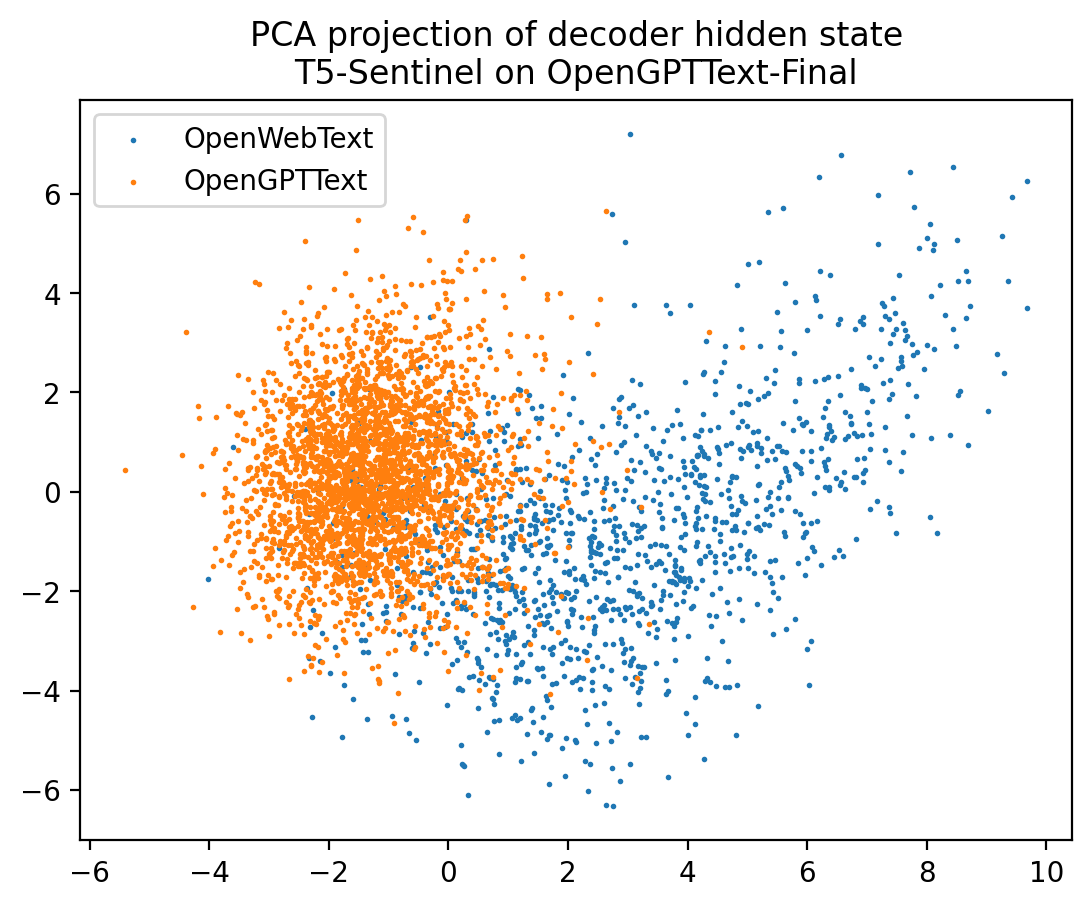

In [11]:
setattr(pca_analysis, "core", None)
pca_analysis(
    hiddens, 
    title="PCA projection of decoder hidden state\nT5-Sentinel on OpenGPTText-Final",
    output="t5_pca_projection_CMCD.pdf",
)